In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import signal
import seaborn as sns
import matplotlib.pyplot as plt
import pywt
import os
import time

In [2]:
for dirname, _, filenames in os.walk('.\data'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

.\data\labels.txt
.\data\P812_M050_2_B_FoG_trial1_annotation.csv
.\data\P812_M050_2_B_FoG_trials.mat
.\data\P812_M050_2_B_FoG_trial_1_emg.csv
.\data\P812_M050_2_B_FoG_trial_1_out_left_foot.csv
.\data\P812_M050_2_B_FoG_trial_1_out_lower_left_foot.csv
.\data\P812_M050_2_B_FoG_trial_1_out_lower_right_foot.csv
.\data\P812_M050_2_B_FoG_trial_1_out_right_foot.csv
.\data\P812_M050_2_B_FoG_trial_2_emg.csv
.\data\P812_M050_2_B_FoG_trial_2_out_left_foot.csv
.\data\P812_M050_2_B_FoG_trial_2_out_lower_left_foot.csv
.\data\P812_M050_2_B_FoG_trial_2_out_lower_right_foot.csv
.\data\P812_M050_2_B_FoG_trial_2_out_right_foot.csv
.\data\P812_M50_2_B_FoG_trial2_annotation.csv


In [3]:
emg_data = pd.read_csv('.\data\P812_M050_2_B_FoG_trial_1_emg.csv')
t1olf = pd.read_csv('.\data\P812_M050_2_B_FoG_trial_1_out_left_foot.csv')
emg_data2 = pd.read_csv('.\data\P812_M050_2_B_FoG_trial_2_emg.csv')

In [4]:
emg_data = emg_data.fillna({'LEFT_BF':emg_data.LEFT_BF.mean(),
                           'LEFT_RF':emg_data.LEFT_RF.mean(),
                           'RIGHT_TA':emg_data.RIGHT_TA.mean(),
                           'RIGHT_TS':emg_data.RIGHT_TS.mean(),
                           'RIGHT_BF':emg_data.RIGHT_BF.mean(),
                           'RIGHT_RF':emg_data.RIGHT_RF.mean()})
emg_data.isna().sum()

Time        0
Label1      0
Label2      0
LEFT_TA     0
LEFT_TS     0
LEFT_BF     0
LEFT_RF     0
RIGHT_TA    0
RIGHT_TS    0
RIGHT_BF    0
RIGHT_RF    0
dtype: int64

In [27]:
def scale_data(data,scaler):
    X = data.iloc[:,3:]
    sc = scaler()
    X = sc.fit_transform(X)
    data.iloc[:,3:] = X
    return data

def generate_window_slide_data(data,width = 260,stride = 30):
    l = len(data)
    end = (l-width)//stride+1
    X = []
    Y = []
    for i in range(end):
        if len(set(data.Label2[i*stride:i*stride+width])) == 1:
                Y += [data.Label2[i*stride]]
                X += [np.array(data.iloc[i*stride:i*stride+width,3:])]
            #print(set(data.Label2[i*stride:i*stride+width]))
        else:
            #print(set(data.Label2[i*stride:i*stride+width]))
            continue
    return np.array(X,dtype=np.float32),np.array(Y,dtype=np.uint8)

#def generate_CWT_feature(data,widths=260,wavelet = signal.ricker):
#    n,t,c = data.shape
#    cwtmatr = np.zeros((n,widths,t,c))
#    for i in range(n):
#        for j in range(c):
#            cwtmatr[i,:,:,j] = signal.cwt(data[i,:,j],wavelet,np.arange(1,widths+1))
#    return cwtmatr


def generate_CWT_feature(data,widths=260,wavelet = 'mexh'):
    n,t,c = data.shape
    cwtmatr = np.zeros((n,widths,t,c))
    for i in range(n):
        for j in range(c):
            cwtmatr[i,:,:,j],_ = pywt.cwt(data[i,:,j],np.arange(1,widths+1),wavelet)
    return cwtmatr

In [36]:
emg_data_sc = scale_data(emg_data,StandardScaler)
#sc = StandardScaler()
#sc.fit_transform(emg_data.iloc[:,3:])
#emg_data_sc.iloc[:,8].plot()

In [38]:
width = 256
stride = 32
widths_scale = 32
x,y = generate_window_slide_data(emg_data_sc,width,stride)

In [39]:
start = time.time()
cwtmatr = generate_CWT_feature(x,widths_scale,'mexh')
end = time.time()
duration = end-start
print('duration: %f'%(duration))

duration: 47.611546


In [119]:
(np.isnan(cwtmatr)).sum()
cwtmatr.max()

['cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'mexh',
 'morl',
 'shan']

In [180]:
pywt.wavelist(kind='continuous')

duration: 51.549625


In [12]:
import h5py

file = './processed data/P812_trial_1_W%d_S%d_WS%d_CWT.hdf5'%(width,stride,widths_scale)
with h5py.File(file,'w') as f:
    f.create_dataset('cwt_data',data=cwtmatr, maxshape=(None,260,260,8),
                     chunks = True,dtype = np.float32)
    f.create_dataset('label2',data=y, dtype = np.int8)

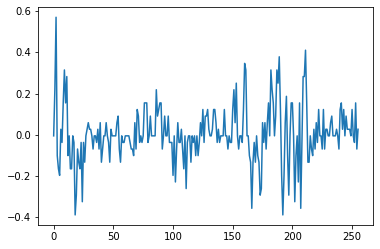

In [40]:
plt.plot(x[1,:,1])

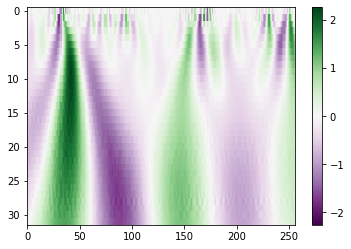

3


In [42]:
temp = 200
channel = 0
plt.imshow(cwtmatr[temp,:,:,channel], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr[temp,:,:,channel]).max(), 
           vmin=-abs(cwtmatr[temp,:,:,channel]).max())
plt.colorbar()
plt.show()
print(y[temp])

In [156]:
#label = y[ind]
#label[label==2]=1


In [44]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import save_model
from tensorflow.keras import callbacks, Model
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import TruncatedNormal
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend as K

In [66]:
ind = ((y==0) | (y==1))
y_02 = y[ind]
y_02[y_02==2]=1
X_train,X_test,y_train,y_test = train_test_split(cwtmatr[ind],y_02,test_size = 0.2,random_state=60)

In [67]:
input_ = layers.Input(shape=cwtmatr.shape[1:])
#max_pool = layers.MaxPooling2D(2)(input_)
conv1 = layers.Conv2D(64,5,strides=(2,2),kernel_initializer=TruncatedNormal(),activation='relu',padding='same')(input_)
max_pool1 = layers.MaxPooling2D(2)(conv1)
conv2 = layers.Conv2D(128,5,strides=(2,2),kernel_initializer=TruncatedNormal(),activation='relu',padding='same')(max_pool1)
max_pool2 = layers.MaxPooling2D(2)(conv2)
flatten = layers.Flatten()(max_pool2)
#layer1 = Dense(256,activation = 'relu')(flatten)
dropout1 = layers.Dropout(0.2)(flatten)
layer2 = layers.Dense(128,activation = 'relu')(dropout1)
dropout2 = layers.Dropout(0.2)(layer2)
output = layers.Dense(2,activation = 'softmax')(dropout2)
model = keras.Model(inputs=[input_],outputs=[output])

In [68]:
#ind = ((y==0) | (y==2))
#bce = CategoricalCrossentropy()
model.compile(loss = 'sparse_categorical_crossentropy' ,optimizer='adam',metrics=['accuracy'])
#oh_ec = OneHotEncoder()
#label = oh_ec.fit_transform(K.eval(y)[ind,tf.newaxis]).toarray()

In [69]:
early_stopping = callbacks.EarlyStopping(patience = 20,monitor = 'val_accuracy', restore_best_weights=True)

In [70]:
history = model.fit(X_train,y_train,validation_data=[X_test,y_test],
                    epochs=100,batch_size=50,
                   callbacks=[early_stopping])

Train on 672 samples, validate on 169 samples
Epoch 1/100
672/672 [==============================] - 4s 7ms/sample - loss: 1.6862 - accuracy: 0.6801 - val_loss: 0.5455 - val_accuracy: 0.8225
Epoch 2/100
672/672 [==============================] - 4s 6ms/sample - loss: 0.5266 - accuracy: 0.7946 - val_loss: 0.4053 - val_accuracy: 0.8402
Epoch 3/100
672/672 [==============================] - 4s 6ms/sample - loss: 0.3971 - accuracy: 0.8393 - val_loss: 0.3373 - val_accuracy: 0.8402
Epoch 4/100
672/672 [==============================] - 4s 6ms/sample - loss: 0.2892 - accuracy: 0.8765 - val_loss: 0.2980 - val_accuracy: 0.8521
Epoch 5/100
672/672 [==============================] - 4s 7ms/sample - loss: 0.1950 - accuracy: 0.9107 - val_loss: 0.2266 - val_accuracy: 0.8817
Epoch 6/100
672/672 [==============================] - 4s 6ms/sample - loss: 0.1218 - accuracy: 0.9583 - val_loss: 0.2380 - val_accuracy: 0.8994
Epoch 7/100
672/672 [==============================] - 4s 6ms/sample - loss: 0.0706 

In [50]:
y_pred = model.predict(cwtmatr[:3])
y_pred

array([[9.741865e-01, 2.581344e-02],
       [9.422290e-06, 9.999906e-01],
       [8.860579e-03, 9.911395e-01]], dtype=float32)

In [34]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 256, 8)]      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 128, 8)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 64, 64)        12864     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 32, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 16, 128)        204928    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 8, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0   

(0, 1)

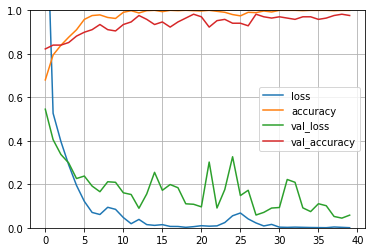

In [71]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,1)

In [203]:
model.save('Mexh_W%d_S%d_WS%d.h5'%(width,stride,widths_scale))